# Pull Request Features

プルリクエストの特徴量とバグ混入の有無の関係を調べる。

### バグ混入の有無でプルリクエストの特徴量に差があるかを検定

In [2]:
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu


def get_significance(p):
    if p >= 0.05:
        return " "
    elif p >= 0.01:
        return "*"
    elif p >= 0.001:
        return "**"
    else:
        return "***"


NUMERIC_COLUMNS = (
    "age",
    "#added",
    "#deleted",
    "#commits",
    "#files",
    "#comments",
    "#review_comments",
    "#approvals",
    "#changes_requested",
)
BOOLEAN_COLUMNS = (
    "intra_branch",
    "fix",
    "test",
)

# プルリクエストの特徴量データを読み込む
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]

# 不具合混入の有無でデータを分割
buggy_df = df[df["buggy"] == True]
clean_df = df[df["buggy"] == False]

result_df = pd.DataFrame()

# ==============================================
# 数値特徴量に対して Mann-Whitney U検定を実行
# ==============================================
for feature in NUMERIC_COLUMNS:
    buggy_values = buggy_df[feature]
    clean_values = clean_df[feature]

    # Mann-Whitney U検定
    stat, p = mannwhitneyu(buggy_values, clean_values)

    # 結果
    result_df = pd.concat(
        [
            result_df,
            pd.DataFrame(
                data={
                    "test": "Mann-Whitney U",
                    "significant": get_significance(p),
                },
                index=[feature],
            ),
        ]
    )

# ==============================================
# 真偽値特徴量に対してカイ二乗検定を実行
# ==============================================
for feature in BOOLEAN_COLUMNS:
    # カイ二乗検定
    table = pd.crosstab(df[feature], df["buggy"])
    stat, p, dof, expected = chi2_contingency(table)

    # 結果
    result_df = pd.concat(
        [
            result_df,
            pd.DataFrame(
                data={
                    "test": "Chi-squared",
                    "significant": get_significance(p),
                },
                index=[feature],
            ),
        ]
    )

# 結果を表示
print(result_df.to_latex())

\begin{tabular}{lll}
\toprule
 & test & significant \\
\midrule
age & Mann-Whitney U & *** \\
#added & Mann-Whitney U & *** \\
#deleted & Mann-Whitney U & *** \\
#commits & Mann-Whitney U & *** \\
#files & Mann-Whitney U & *** \\
#comments & Mann-Whitney U & *** \\
#review_comments & Mann-Whitney U & *** \\
#approvals & Mann-Whitney U & *** \\
#changes_requested & Mann-Whitney U & *** \\
intra_branch & Chi-squared &   \\
fix & Chi-squared & *** \\
test & Chi-squared & *** \\
\bottomrule
\end{tabular}



### 機械学習モデルを使用して，予測精度と特徴量重要度を算出

{'model': 'L.R.', 'age': np.float64(0.000811030008110325), '#commits': np.float64(0.005961070559610737), '#added': np.float64(-8.110300081103361e-05), '#deleted': np.float64(0.0008110300081103361), '#files': np.float64(0.002676399026763998), '#comments': np.float64(-0.00012165450121655041), '#review_comments': np.float64(0.0005271695052716851), 'intra_branch': np.float64(-0.0005271695052716963), '#approvals': np.float64(-0.0002838605028386065), '#changes_requested': np.float64(4.0551500405516806e-05), 'fix': np.float64(0.002108678021086785), 'test': np.float64(0.0004460665044606849)}
{'model': 'D.T.', 'age': np.float64(0.00579886455798867), '#commits': np.float64(0.02570965125709653), '#added': np.float64(0.00875912408759123), '#deleted': np.float64(0.007339821573398231), '#files': np.float64(0.016058394160583966), '#comments': np.float64(0.009732360097323622), '#review_comments': np.float64(0.0010543390105434147), 'intra_branch': np.float64(0.000770478507704797), '#approvals': np.floa

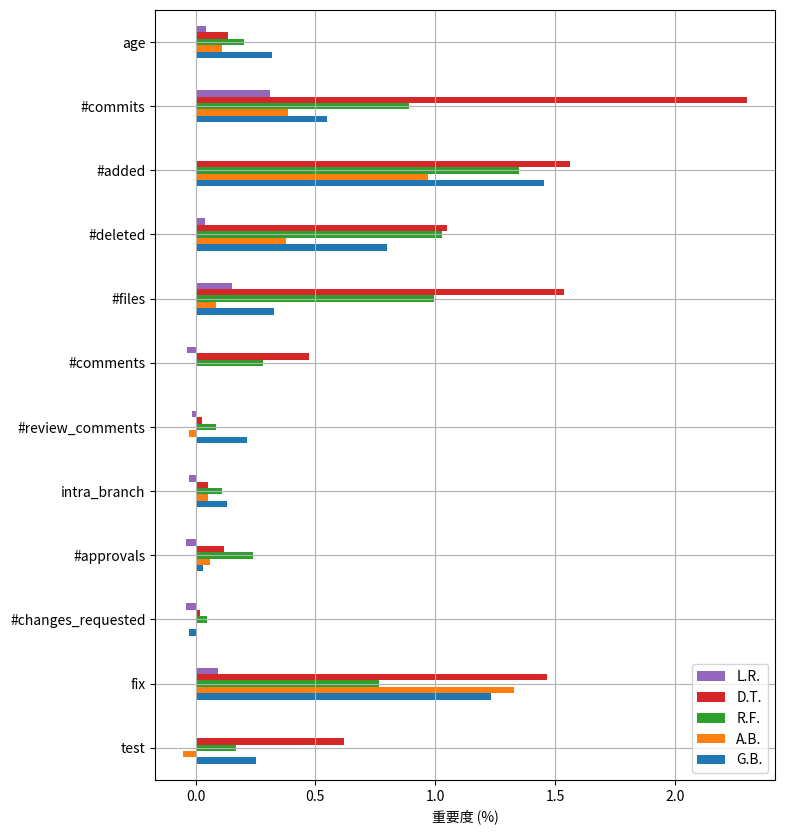

\begin{tabular}{lrrrrr}
\toprule
model & L.R. & D.T. & R.F. & A.B. & G.B. \\
\midrule
age & 0.04 & 0.14 & 0.20 & 0.11 & 0.32 \\
\#commits & 0.31 & 2.30 & 0.89 & 0.39 & 0.55 \\
\#added & 0.01 & 1.56 & 1.35 & 0.97 & 1.46 \\
\#deleted & 0.04 & 1.05 & 1.03 & 0.38 & 0.80 \\
\#files & 0.15 & 1.54 & 0.99 & 0.09 & 0.33 \\
\#comments & -0.04 & 0.47 & 0.28 & 0.00 & 0.01 \\
\#review\_comments & -0.01 & 0.03 & 0.09 & -0.03 & 0.21 \\
intra\_branch & -0.03 & 0.05 & 0.11 & 0.05 & 0.13 \\
\#approvals & -0.04 & 0.12 & 0.24 & 0.06 & 0.03 \\
\#changes\_requested & -0.04 & 0.02 & 0.05 & 0.00 & -0.03 \\
fix & 0.09 & 1.47 & 0.77 & 1.33 & 1.23 \\
test & 0.01 & 0.62 & 0.17 & -0.05 & 0.25 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
model & L.R. & D.T. & R.F. & A.B. & G.B. \\
\midrule
accuracy & 0.82 & 0.75 & 0.83 & 0.82 & 0.83 \\
precision & 0.47 & 0.31 & 0.61 & 0.58 & 0.56 \\
recall & 0.04 & 0.34 & 0.18 & 0.13 & 0.18 \\
f1 & 0.07 & 0.32 & 0.28 & 0.20 & 0.28 \\
auc & 0.66 & 0.59 & 0.74 & 0.7

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

EXCLUDE_COLUMNS = ["project", "id", "url", "bot", "code_change"]

# プルリクエストの特徴量データを読み込み
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]
df = df.drop(EXCLUDE_COLUMNS, axis=1)
X, y = df.drop("buggy", axis=1), df["buggy"]

# データを標準化
X = (X - X.mean()) / X.std()

# モデルの設定
models = {
    "L.R.": LogisticRegression(),
    "D.T.": DecisionTreeClassifier(random_state=0),
    "R.F.": RandomForestClassifier(class_weight="balanced", random_state=0),
    "A.B.": AdaBoostClassifier(random_state=0),
    "G.B.": GradientBoostingClassifier(random_state=0),
    # "XGB": xgb.XGBClassifier(),
}

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

# 特徴量の重要度を保持するデータフレーム
importances_df = pd.DataFrame()

# モデルの精度を保持するデータフレーム
scores_df = pd.DataFrame()

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for model_name, model in models.items():
        # モデルの学習
        model.fit(X_train, y_train)

        # モデルの精度の計算 (Accuracy, Precision, Recall, F1-Score, AUC, MCC)
        y_pred = model.predict(X_test)
        row = {
            "model": model_name,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            "mcc": matthews_corrcoef(y_test, y_pred),
        }

        scores_df = pd.concat(
            [
                scores_df,
                pd.DataFrame([row]),
            ],
            ignore_index=True,
        )

        # 特徴量の重要度の計算
        result = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=0
        )

        # 結果の保存
        row = {
            "model": model_name,
        } | {
            feature: result.importances_mean[i]
            for i, feature in enumerate(X_test.columns)
        }
        print(row)
        importances_df = pd.concat(
            [
                importances_df,
                pd.DataFrame([row]),
            ],
            ignore_index=True,
        )

# ==============================
# 結果の可視化
# ==============================
importances_df = importances_df.groupby("model").mean() * 100
importances_df = importances_df.T[models.keys()]
scores_df = scores_df.groupby("model").mean()
plt.rc("font", family="Noto Sans CJK JP")
ax = importances_df.iloc[::-1, ::-1].plot.barh(figsize=(8, 10))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.grid()
plt.xlabel("重要度 (%)")
plt.show()
print(importances_df.to_latex(float_format="%.2f", escape=True))
print(scores_df.T[models.keys()].to_latex(float_format="%.2f", escape=True))

### ロジスティック回帰分析

In [ ]:
import numpy as np
import polars as pl
import statsmodels.api as sm

EXCLUDE_COLUMNS = ["project", "id", "url", "bot", "code_change"]

# プルリクエストの特徴量データを読み込み
df = (
    pl.read_csv("data/pull_request_features.csv")
    .filter(pl.col("bot") == False)
    .filter(pl.col("code_change") == True)
    .drop(EXCLUDE_COLUMNS)
)

# ロジスティック回帰分析
X = df.drop("buggy").to_pandas()
X = sm.add_constant(X)
y = df["buggy"].to_numpy()
model = sm.Logit(y, X.astype(float))
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.448142
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4931
Model:                          Logit   Df Residuals:                     4918
Method:                           MLE   Df Model:                           12
Date:                Sat, 01 Feb 2025   Pseudo R-squ.:                 0.04896
Time:                        17:11:18   Log-Likelihood:                -2209.8
converged:                       True   LL-Null:                       -2323.6
Covariance Type:            nonrobust   LLR p-value:                 6.455e-42
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.1278      0.076    -28.024      0.000      -2.277      -1.979
age  